In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import root_mean_squared_error
import re

#hyperparameters
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30 

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# Sequence creation function
def create_sequences_from_combined_array(all_scaled_data, seq_len, list_of_target_indices_in_data):
    Xs, ys = [], []
    all_scaled_data_np = np.array(all_scaled_data)
    if all_scaled_data_np.ndim == 1:
        all_scaled_data_np = all_scaled_data_np.reshape(-1,1)
    for i in range(len(all_scaled_data_np) - seq_len):
        Xs.append(all_scaled_data_np[i:(i + seq_len), :]) 
        ys.append(all_scaled_data_np[i + seq_len, list_of_target_indices_in_data])
    return np.array(Xs), np.array(ys)

In [2]:
# --- Centralized Data Loading & Preprocessing for S&P.ipynb ---
df_sp = pd.read_csv("S&P500 5Y.csv") # Corrected filename

# Initial column cleanup and type conversion
df_sp['Date'] = pd.to_datetime(df_sp['Date'])
df_sp.rename(columns={
    'Close/Last': 'CloseLast'
}, inplace=True) # S&P CSV also has fewer columns like Vol. or Change %

df_sp.set_index('Date', inplace=True)
df_sp.sort_index(inplace=True)

# Define features and target
# S&P CSV typically contains: Date, Close/Last, Open, High, Low
# !!! IMPORTANT: Review and adjust 'features_for_scaling' and 'target_col_name' to your actual needs! !!!
target_col_name = 'CloseLast' 
features_to_include = ['Open', 'High', 'Low', 'CloseLast'] # No Vol. or Change % in S&P CSV

features_present_in_df = [f for f in features_to_include if f in df_sp.columns]

features_for_scaling = list(features_present_in_df)
if target_col_name not in features_for_scaling and target_col_name in df_sp.columns:
    features_for_scaling.append(target_col_name)
features_for_scaling = list(dict.fromkeys(features_for_scaling))

if target_col_name not in features_for_scaling:
    raise ValueError(f"Target column '{target_col_name}' must be in 'features_for_scaling'. Available: {df_sp.columns.tolist()}")

target_idx_in_scaled_data = [features_for_scaling.index(target_col_name)]

df_processed = df_sp[features_for_scaling].copy()
df_processed.dropna(inplace=True) # Handle any NaNs if present

data_to_scale = df_processed.values
dates_processed = df_processed.index

# --- Data Splitting (by year) ---
train_start_year, train_end_year = 2019, 2023
test_year = 2024
final_val_year = 2025

train_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= train_end_year)
test_idx_bool = dates_processed.year == test_year
val2025_idx_bool = dates_processed.year == final_val_year
trainval_idx_bool = (dates_processed.year >= train_start_year) & (dates_processed.year <= test_year)

# --- Scaling (Fit ONLY on initial training data) ---
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(data_to_scale[train_idx_bool])

scaled_test_data = scaler.transform(data_to_scale[test_idx_bool])
scaled_val2025_data = scaler.transform(data_to_scale[val2025_idx_bool])
scaled_trainval_data = scaler.transform(data_to_scale[trainval_idx_bool])

# --- Sequence Creation for all datasets ---
X_train, y_train = create_sequences_from_combined_array(scaled_train_data, SEQ_LEN, target_idx_in_scaled_data)
X_test, y_test = create_sequences_from_combined_array(scaled_test_data, SEQ_LEN, target_idx_in_scaled_data)
X_val2025, y_val2025 = create_sequences_from_combined_array(scaled_val2025_data, SEQ_LEN, target_idx_in_scaled_data)
X_trainval, y_trainval = create_sequences_from_combined_array(scaled_trainval_data, SEQ_LEN, target_idx_in_scaled_data)

# --- Corresponding Dates for Sequences ---
dates_train_seq = dates_processed[train_idx_bool][SEQ_LEN:]
dates_test_seq = dates_processed[test_idx_bool][SEQ_LEN:]
dates_val2025_seq = dates_processed[val2025_idx_bool][SEQ_LEN:]
dates_trainval_seq = dates_processed[trainval_idx_bool][SEQ_LEN:]

print(f"Shape of X_train for S&P: {X_train.shape}, y_train: {y_train.shape}")
print(f"Features for S&P scaling: {features_for_scaling}")
print(f"Target index for S&P: {target_idx_in_scaled_data}")

Shape of X_train for S&P: (888, 20, 4), y_train: (888, 1)
Features for S&P scaling: ['Open', 'High', 'Low', 'CloseLast']
Target index for S&P: [3]


In [3]:
# --- Model Definitions (Copied, output_size=1 is default) ---
class StockGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

In [4]:
# --- Initial Training and Evaluation (Train: 2019-2023, Test: 2024) for all models ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset_init_sp = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_init_sp = DataLoader(train_dataset_init_sp, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_init_sp = TensorDataset(X_test_tensor, y_test_tensor)
test_loader_init_sp = DataLoader(test_dataset_init_sp, batch_size=BATCH_SIZE, shuffle=False)

input_size_init_sp = X_train.shape[2]
initial_models_sp = {}
initial_results_sp = {}

model_classes_sp = {"GRU": StockGRU, "LSTM": StockLSTM, "RNN": StockRNN}
plot_colors_init_sp = {"GRU": "blue", "LSTM": "green", "RNN": "red"}

for model_name, ModelClass in model_classes_sp.items():
    print(f"--- Initial Training for S&P {model_name} ---")
    H_init, L_init, LR_init = 64, 2, 0.001
    
    model = ModelClass(input_size_init_sp, H_init, L_init, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_init)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for X_batch, y_batch in train_loader_init_sp:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Initial S&P {model_name}: Epoch [{epoch+1}/{N_EPOCHS}], Loss: {loss.item():.4f}')
    initial_models_sp[model_name] = model
    
    model.eval()
    preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader_init_sp:
            output = model(X_batch)
            preds_scaled.extend(output.numpy())
    preds_scaled = np.array(preds_scaled)
    
    dummy_preds = np.zeros((len(preds_scaled), len(features_for_scaling)))
    dummy_preds[:, target_idx_in_scaled_data[0]] = preds_scaled.flatten()
    preds_inversed = scaler.inverse_transform(dummy_preds)[:, target_idx_in_scaled_data[0]]
    
    dummy_actuals = np.zeros((len(y_test), len(features_for_scaling)))
    dummy_actuals[:, target_idx_in_scaled_data[0]] = y_test.flatten()
    actuals_inversed = scaler.inverse_transform(dummy_actuals)[:, target_idx_in_scaled_data[0]]
    
    rmse = root_mean_squared_error(actuals_inversed, preds_inversed)
    print(f'Initial S&P {model_name} - Test RMSE (2024): {rmse:.2f}')
    initial_results_sp[model_name] = {'rmse': rmse, 'preds_inversed': preds_inversed, 'actuals_inversed': actuals_inversed}

plt.figure(figsize=(15, 7))
plt.plot(dates_test_seq, initial_results_sp["GRU"]['actuals_inversed'], label='Actual Price (2024)', color='black', linewidth=2)
for model_name in initial_models_sp.keys():
    plt.plot(dates_test_seq, initial_results_sp[model_name]['preds_inversed'], 
             label=f'S&P {model_name} Predicted (RMSE: {initial_results_sp[model_name]["rmse"]:.2f})', 
             color=plot_colors_init_sp[model_name], linestyle='--')
plt.title(f'S&P Initial Model Predictions vs Actual - Test Set (2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

--- Initial Training for S&P GRU ---
Initial S&P GRU: Epoch [10/30], Loss: 0.0008
Initial S&P GRU: Epoch [20/30], Loss: 0.0006
Initial S&P GRU: Epoch [30/30], Loss: 0.0005
Initial S&P GRU - Test RMSE (2024): 117.95
--- Initial Training for S&P LSTM ---
Initial S&P LSTM: Epoch [10/30], Loss: 0.0023
Initial S&P LSTM: Epoch [20/30], Loss: 0.0011
Initial S&P LSTM: Epoch [30/30], Loss: 0.0015
Initial S&P LSTM - Test RMSE (2024): 160.96
--- Initial Training for S&P RNN ---
Initial S&P RNN: Epoch [10/30], Loss: 0.0010
Initial S&P RNN: Epoch [20/30], Loss: 0.0006
Initial S&P RNN: Epoch [30/30], Loss: 0.0008
Initial S&P RNN - Test RMSE (2024): 181.55


## Hyperparameter Tuning & Final Validation (Train: 2019-2024, Validate: 2025)

In [5]:
X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32)
X_final_val_tensor = torch.tensor(X_val2025, dtype=torch.float32)
y_final_val_tensor = torch.tensor(y_val2025, dtype=torch.float32)

trainval_dataset_sp = TensorDataset(X_trainval_tensor, y_trainval_tensor)
trainval_loader_sp = DataLoader(trainval_dataset_sp, batch_size=BATCH_SIZE, shuffle=True)

final_val_dataset_sp = TensorDataset(X_final_val_tensor, y_final_val_tensor)
final_val_loader_sp = DataLoader(final_val_dataset_sp, batch_size=BATCH_SIZE, shuffle=False)

print(f"Shape of X_trainval_tensor for S&P: {X_trainval_tensor.shape}")

Shape of X_trainval_tensor for S&P: torch.Size([1140, 20, 4])


In [6]:
param_grid_sp = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}
all_params_tuning_sp = [dict(zip(param_grid_sp.keys(), v)) for v in product(*param_grid_sp.values())]

results_tuning_sp = {}
best_configs_tuning_sp = {}
best_model_states_tuning_sp = {}

input_size_tuning_sp = X_trainval.shape[2]

for model_name, ModelClass in model_classes_sp.items():
    print(f"\n--- Hyperparameter Tuning for S&P {model_name} ---")
    best_val_rmse_model_sp = float('inf')
    best_params_model_sp = None
    best_model_state_model_sp = None
    model_tuning_log_sp = []

    for params in all_params_tuning_sp:
        H, L, LR = params['hidden_size'], params['num_layers'], params['learning_rate']
        
        current_model_tuning = ModelClass(input_size_tuning_sp, H, L, output_size=1)
        criterion_tuning = nn.MSELoss()
        optimizer_tuning = torch.optim.Adam(current_model_tuning.parameters(), lr=LR)
        
        for epoch in range(N_EPOCHS // 2):
            current_model_tuning.train()
            for X_batch, y_batch in trainval_loader_sp:
                optimizer_tuning.zero_grad()
                output = current_model_tuning(X_batch)
                loss = criterion_tuning(output, y_batch)
                loss.backward()
                optimizer_tuning.step()
        
        current_model_tuning.eval()
        current_val_preds_scaled = []
        with torch.no_grad():
            for X_batch, y_batch in final_val_loader_sp:
                output = current_model_tuning(X_batch)
                current_val_preds_scaled.extend(output.numpy())
        current_val_preds_scaled = np.array(current_val_preds_scaled)
        
        dummy_preds_val = np.zeros((len(current_val_preds_scaled), len(features_for_scaling)))
        dummy_preds_val[:, target_idx_in_scaled_data[0]] = current_val_preds_scaled.flatten()
        current_val_preds_inversed = scaler.inverse_transform(dummy_preds_val)[:, target_idx_in_scaled_data[0]]
        
        dummy_actuals_val = np.zeros((len(y_val2025), len(features_for_scaling)))
        dummy_actuals_val[:, target_idx_in_scaled_data[0]] = y_val2025.flatten()
        y_val2025_inversed = scaler.inverse_transform(dummy_actuals_val)[:, target_idx_in_scaled_data[0]]
        
        current_rmse_val = root_mean_squared_error(y_val2025_inversed, current_val_preds_inversed)
        model_tuning_log_sp.append({'params': params, 'val_rmse': current_rmse_val})
        
        if current_rmse_val < best_val_rmse_model_sp:
            best_val_rmse_model_sp = current_rmse_val
            best_params_model_sp = params
            best_model_state_model_sp = current_model_tuning.state_dict()
            
    results_tuning_sp[model_name] = {
        'best_val_rmse_2025': best_val_rmse_model_sp,
        'best_params': best_params_model_sp,
        'log': model_tuning_log_sp,
        'actual_2025': y_val2025_inversed
    }
    best_configs_tuning_sp[model_name] = best_params_model_sp
    best_model_states_tuning_sp[model_name] = best_model_state_model_sp
    print(f"Best Validation RMSE for S&P {model_name} (2025): {best_val_rmse_model_sp:.2f} with params: {best_params_model_sp}")


--- Hyperparameter Tuning for S&P GRU ---
Best Validation RMSE for S&P GRU (2025): 102.80 with params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}

--- Hyperparameter Tuning for S&P LSTM ---
Best Validation RMSE for S&P LSTM (2025): 136.85 with params: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001}

--- Hyperparameter Tuning for S&P RNN ---
Best Validation RMSE for S&P RNN (2025): 102.37 with params: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001}


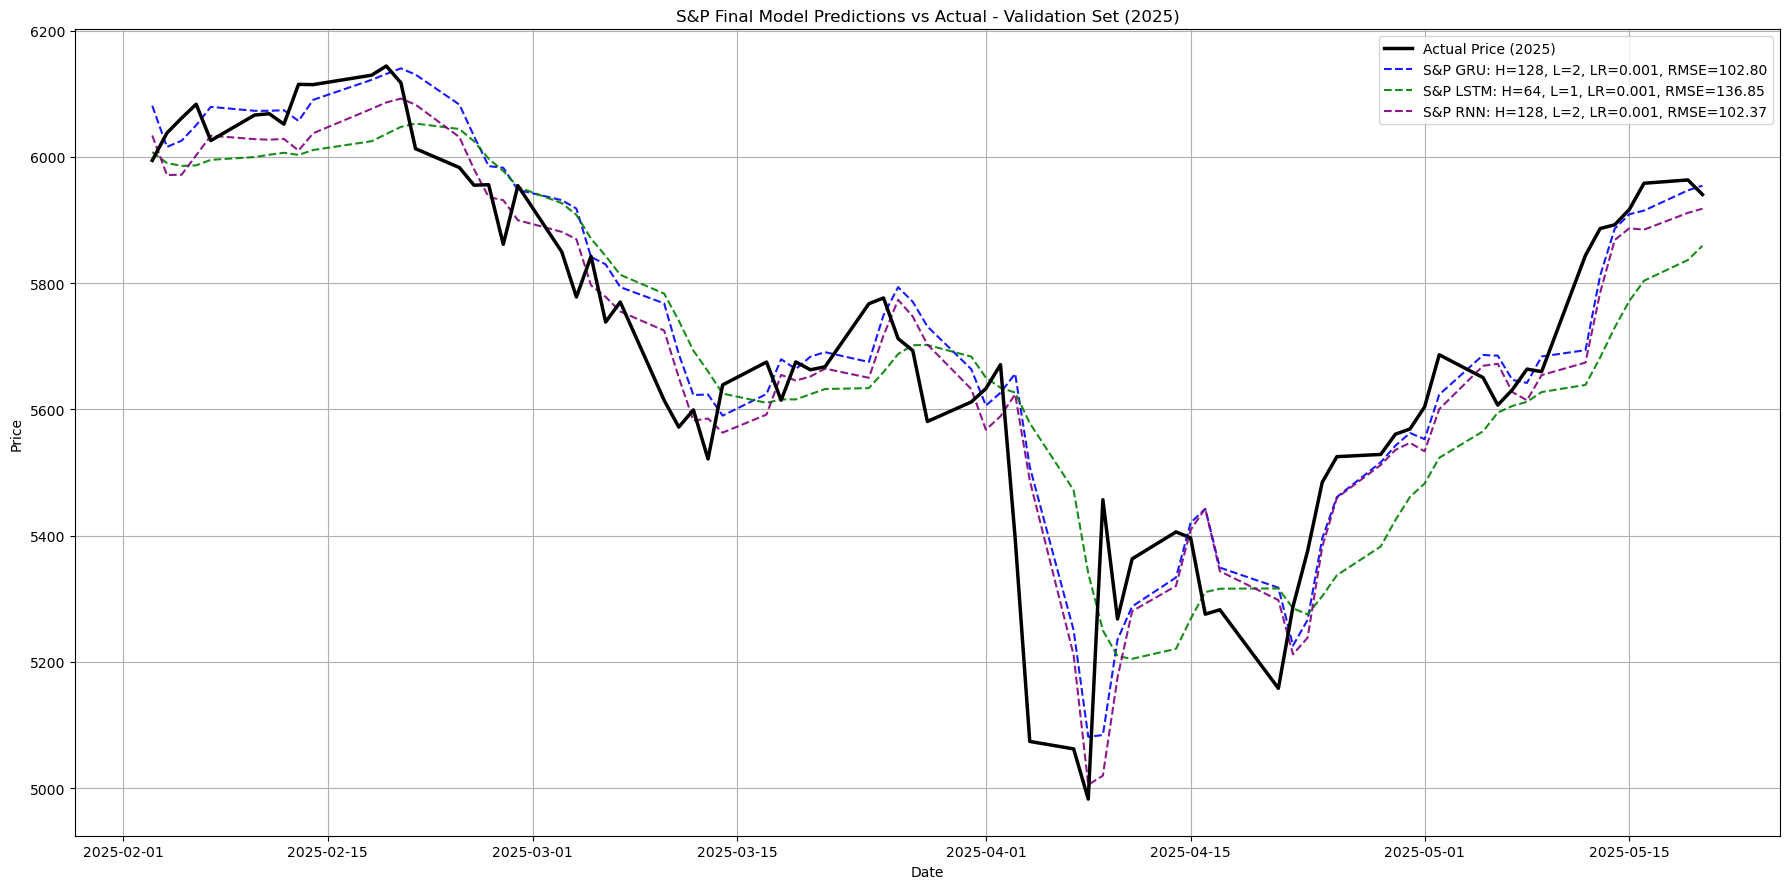

In [7]:
# --- Final Evaluation and Plotting with Best Tuned Models on 2025 Validation Set ---
plt.figure(figsize=(18, 9))

actual_2025_data_for_plot_sp = results_tuning_sp.get("GRU", {}).get("actual_2025")
if actual_2025_data_for_plot_sp is not None:
    plt.plot(dates_val2025_seq, actual_2025_data_for_plot_sp, label='Actual Price (2025)', color='black', linewidth=2.5, zorder=5)

final_plot_colors_sp = {"GRU": "blue", "LSTM": "green", "RNN": "purple"} 

for model_name, ModelClass in model_classes_sp.items():
    if model_name not in best_configs_tuning_sp or best_configs_tuning_sp[model_name] is None:
        print(f"No best configuration found for S&P {model_name}. Skipping final plot.")
        continue
        
    best_params = best_configs_tuning_sp[model_name]
    best_model_final = ModelClass(input_size_tuning_sp, 
                                  best_params['hidden_size'], 
                                  best_params['num_layers'], 
                                  output_size=1)
    if best_model_states_tuning_sp[model_name] is not None:
        best_model_final.load_state_dict(best_model_states_tuning_sp[model_name])
    else:
        print(f"No model state found for S&P {model_name}. Skipping final plot.")
        continue
    best_model_final.eval()
    
    final_preds_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader_sp:
            output = best_model_final(X_batch)
            final_preds_scaled.extend(output.numpy())
    final_preds_scaled = np.array(final_preds_scaled)
    
    dummy_final_preds = np.zeros((len(final_preds_scaled), len(features_for_scaling)))
    dummy_final_preds[:, target_idx_in_scaled_data[0]] = final_preds_scaled.flatten()
    final_preds_inversed = scaler.inverse_transform(dummy_final_preds)[:, target_idx_in_scaled_data[0]]
    
    results_tuning_sp[model_name]['pred_2025_final_best'] = final_preds_inversed
    final_rmse = results_tuning_sp[model_name]['best_val_rmse_2025']
    
    legend_label = f"S&P {model_name}: H={best_params['hidden_size']}, L={best_params['num_layers']}, LR={best_params['learning_rate']}, RMSE={final_rmse:.2f}"
    plt.plot(dates_val2025_seq, final_preds_inversed, 
             label=legend_label, 
             color=final_plot_colors_sp[model_name], 
             linestyle='--', alpha=0.9)

plt.title(f'S&P Final Model Predictions vs Actual - Validation Set (2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()